## Logistic Regression

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification # For generating classification data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Plotting configuration
sns.set_theme(style="whitegrid")
print(f"PyTorch Version: {torch.__version__}")

torch.manual_seed(42)
np.random.seed(42)

PyTorch Version: 2.3.0+cu118


### Introduction to Logistic Regression
<p>Logistic Regression is a linear model used for binary classification problems (where the target variable y can take one of two values, e.g. 0 or 1, True or False). </p>
<p>Despite its name, Logistic Regression is a classification algorithm, not a regression algorithm. It models the probability that an input X belongs to a particular class.</p>

#### Sigmoid (Logistic) Function
<p>The sigmoid function squashes any real-valued number into the range (0,1), which is ideal for representing a probability.</p></br>
Formula: σ(z) = 1 / (1 + e^(-z))

In [4]:
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

In [7]:
z_vals_torch = torch.linspace(-10, 10, 200)

In [8]:
sigma_vals_torch = sigmoid(z_vals_torch)

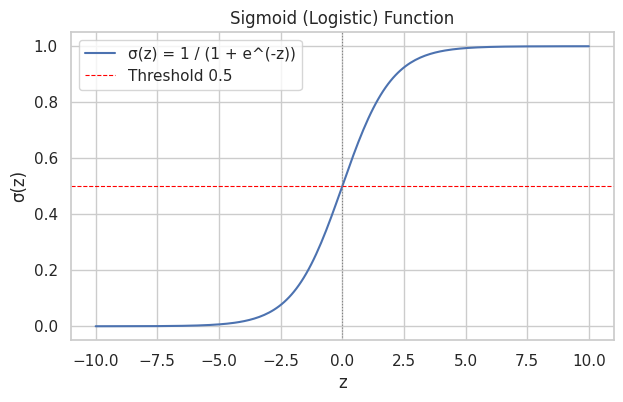

In [13]:
plt.figure(figsize=(7, 4))
plt.plot(z_vals_torch, sigma_vals_torch, label="σ(z) = 1 / (1 + e^(-z))")
plt.title("Sigmoid (Logistic) Function")
plt.xlabel("z")
plt.ylabel("σ(z)")
plt.axhline(0.5, color='red', linestyle='--', linewidth=0.8, label="Threshold 0.5")
plt.axvline(0, color='grey', linestyle=':', linewidth=0.8)
plt.legend(); plt.grid(True); plt.show()

#### Hypothesis Function
<p>For an input X, the linear part is z = X @ θ (or z = wX + b). The hypothesis is the probability P(y=1 | X; θ):</p> </br>
h_θ(X) = σ(X @ θ) = σ(wX + b)

#### Cost Function: Binary Cross-Entropy (BCE) Loss/ Log Loss
<p>Measures the performance of a classification model whose output is a probability value between 0 and 1.</p> </br>
For a single training example (x, y): </br></br>
<p>Cost(h_θ(x), y) = -[y * log(h_θ(x)) + (1-y) * log(1 - h_θ(x))]</p>

- If y = 1, Cost = -log(h_θ(x)). We want h_θ(x) to be close to 1 (log(1)=0).
- If y = 0, Cost = -log(1 - h_θ(x)). We want h_θ(x) to be close to 0 (log(1-0)=0).

### Generate Synthetic 2D Binary Classification data

In [15]:
N_SAMPLES_TOTAL = 200

In [25]:
X_numpy_orig, y_numpy_orig = make_classification(
    n_samples=N_SAMPLES_TOTAL,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    flip_y=0.05, 
    class_sep=1.5,
    random_state=42
)

In [26]:
# Standardize features
scaler = StandardScaler()
X_scaled_numpy = scaler.fit_transform(X_numpy_orig)

In [45]:
X = torch.from_numpy(X_scaled_numpy.astype(np.float32))
y = torch.from_numpy(y_numpy_orig.astype(np.float32)).unsqueeze(1)     # Reshape y to [N, 1]

In [46]:
X.dtype

torch.float32

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [48]:
X_train.shape, y_train.shape

(torch.Size([150, 2]), torch.Size([150, 1]))

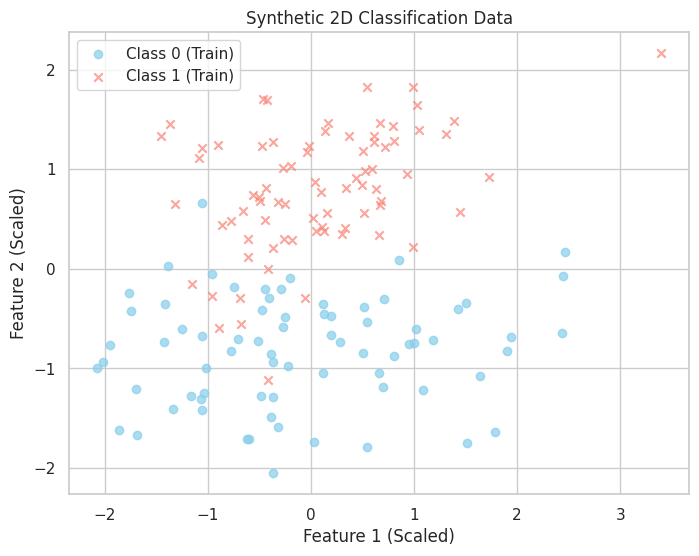

In [49]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[y_train.squeeze() == 0][:, 0], X_train[y_train.squeeze() == 0][:, 1],
            label='Class 0 (Train)', marker='o', c='skyblue', alpha=0.7)
plt.scatter(X_train[y_train.squeeze() == 1][:, 0], X_train[y_train.squeeze() == 1][:, 1],
            label='Class 1 (Train)', marker='x', c='salmon', alpha=0.7)
plt.xlabel("Feature 1 (Scaled)")
plt.ylabel("Feature 2 (Scaled)")
plt.title("Synthetic 2D Classification Data")
plt.legend(); plt.show()

### Logistic Regression Implementation

In [50]:
def bce_loss(y_true, y_pred):
    # add epsilon to prevent log(0)
    epsilon = 1e-7
    y_pred = torch.clamp(y_pred, epsilon, 1-epsilon)
    loss = - (y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return torch.mean(loss)

In [51]:
# Parameters
# For z = X@weights + bias
n_features = X_train.shape[1]
weights = torch.randn(n_features, 1, requires_grad=True, dtype=torch.float32)    # [n_features, 1]
bias = torch.randn(1, requires_grad=True, dtype=torch.float32)      # [1]

In [52]:
weights.data.flatten(), bias.item()

(tensor([ 0.2303, -1.1229]), -0.18632829189300537)

In [53]:
# Hyperparameters
lr = 0.1
epochs = 500

In [54]:
X_train.dtype, weights.dtype

(torch.float32, torch.float32)

In [56]:
loss_history = []
for epoch in range(epochs):
    # Compute linear output (logits)
    logits = X_train @ weights + bias
    # Apply sigmoid to get probabilities
    y_predicted = sigmoid(logits)
    # compute BCE loss
    loss = bce_loss(y_train, y_predicted)
    loss_history.append(loss.item())
    # Backward pass: Compute gradients
    if weights.grad is not None: weights.grad.zero_()
    if bias.grad is not None: bias.grad.zero_()
    loss.backward()
    # update parameters
    with torch.no_grad():
        weights -= lr * weights.grad
        bias -= lr * bias.grad

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [100/500], Loss: 0.3204
Epoch [200/500], Loss: 0.2557
Epoch [300/500], Loss: 0.2351
Epoch [400/500], Loss: 0.2255
Epoch [500/500], Loss: 0.2202


In [60]:
print(f"Learned weights_manual: {weights.data.flatten()}")
print(f"Learned bias_manual: {bias.item():.4f}")

Learned weights_manual: tensor([-0.2821,  3.3238])
Learned bias_manual: 0.1089


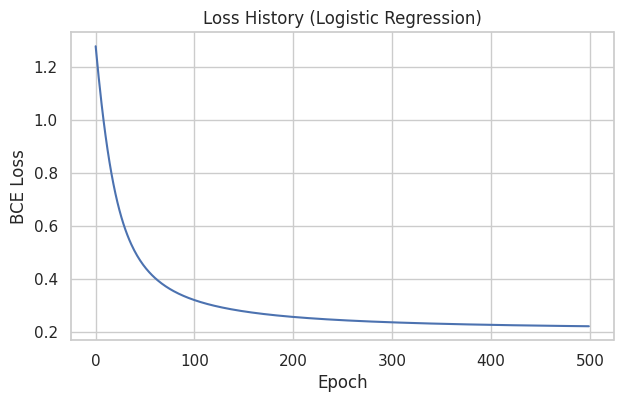

In [62]:
plt.figure(figsize=(7,4))
plt.plot(loss_history)
plt.title("Loss History (Logistic Regression)")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.show()

### Logistic Regression using torch

In [66]:
class PyTorchLogisticRegression(nn.Module):
    def __init__(self, input_features):
        super(PyTorchLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_features, 1)

    def forward(self, x):
        logits = self.linear(x)
        probs = torch.sigmoid(logits)
        return probs

In [67]:
model_nn = PyTorchLogisticRegression(n_features)
model_nn

PyTorchLogisticRegression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

In [69]:
model_nn.linear.weight.data.flatten(), model_nn.linear.bias.item()

(tensor([0.5224, 0.0958]), 0.34095847606658936)

In [71]:
# loss function: Binary cross entropy
criterion_nn = nn.BCELoss()
# Alternative: `nn.BCEWithLogitsLoss`
# This is numerically more stable as it combines sigmoid and BCE in one step,
# expecting raw logits as input.

In [72]:
lr_nn = 0.1
optimizer_nn = optim.SGD(model_nn.parameters(), lr=lr_nn)
epochs_nn = 500

In [74]:
optimizer_nn

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [76]:
loss_history_nn = []
for epoch in range(epochs_nn):
    # Forward pass: get proablitiy predictons from the model
    y_pred_nn = model_nn(X_train)
    # BCELoss
    loss_nn = criterion_nn(y_pred_nn, y_train)
    # If using BCEWithLogitsLoss, you would pass raw logits:
    # logits_nn = model_nn.linear(X_train)
    # loss_nn = criterion_nn_bce_logits(logits_nn, y_train)
    loss_history_nn.append(loss_nn.item())
    # backward pass
    optimizer_nn.zero_grad()
    loss_nn.backward()
    # update parameters
    optimizer_nn.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs_nn}], Loss: {loss_nn.item():.4f}")

Epoch [100/500], Loss: 0.2967
Epoch [200/500], Loss: 0.2493
Epoch [300/500], Loss: 0.2323
Epoch [400/500], Loss: 0.2240
Epoch [500/500], Loss: 0.2193


In [80]:
f"learned nn.Linear weights: {model_nn.linear.weight.data.flatten()}" 

'learned nn.Linear weights: tensor([-0.2885,  3.3680])'

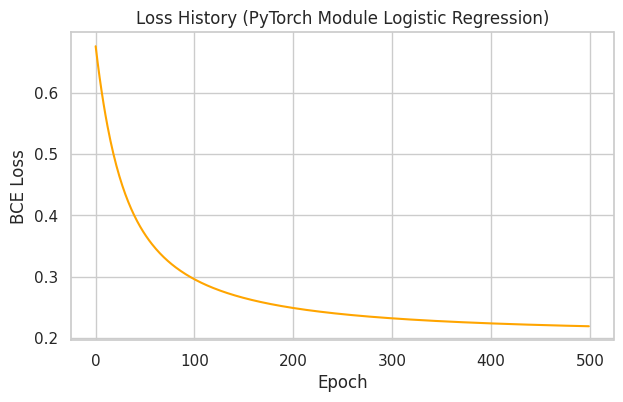

In [81]:
plt.figure(figsize=(7,4))
plt.plot(loss_history_nn, color='orange')
plt.title("Loss History (PyTorch Module Logistic Regression)")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.show()

### Visualizing the Decision Boundary
<p>The decision boundary is where P(y=1|X) = 0.5, which means z = Xw + b = 0.</p>
<p>For 2D features (x1, x2): w1*x1 + w2*x2 + b = 0</p>
<p>So, x2 = (-w1*x1 - b) / w2</p>

In [85]:
def plot_decision_boundary(X_data, y_data, weights, bias, title="Decision Boundary"):
    plt.figure(figsize=(8,6))
    
    # Convert inputs to torch tensors if they aren't already
    if not isinstance(X_data, torch.Tensor):
        X_data = torch.tensor(X_data, dtype=torch.float32)
    if not isinstance(y_data, torch.Tensor):
        y_data = torch.tensor(y_data, dtype=torch.float32)
    if not isinstance(weights, torch.Tensor):
        weights = torch.tensor(weights, dtype=torch.float32)
    if not isinstance(bias, torch.Tensor):
        bias = torch.tensor(bias, dtype=torch.float32)
    
    # Detach tensors to prevent gradient tracking issues
    X_data_np = X_data.detach().numpy()
    y_data_np = y_data.detach().numpy()
    weights_detached = weights.detach()
    bias_detached = bias.detach()
    
    # Plot data points
    class_0_mask = y_data_np.squeeze() == 0
    class_1_mask = y_data_np.squeeze() == 1
    
    plt.scatter(X_data_np[class_0_mask, 0], X_data_np[class_0_mask, 1],
                label='Class 0', marker='o', c='skyblue', alpha=0.7, edgecolors='k')
    plt.scatter(X_data_np[class_1_mask, 0], X_data_np[class_1_mask, 1],
                label='Class 1', marker='x', c='salmon', alpha=0.7, edgecolors='k')

    # Calculate decision boundary line
    x1_min, x1_max = X_data_np[:, 0].min() - 1, X_data_np[:, 0].max() + 1
    x1_vals_db = torch.tensor([x1_min, x1_max], dtype=torch.float32)

    # Handle different weight tensor shapes
    if weights_detached.ndim == 1 and weights_detached.shape[0] == 2: 
        w1 = weights_detached[0]
        w2 = weights_detached[1]
    elif weights_detached.ndim == 2 and weights_detached.shape[0] == 2 and weights_detached.shape[1] == 1: 
        w1 = weights_detached[0, 0]
        w2 = weights_detached[1, 0]
    elif weights_detached.ndim == 2 and weights_detached.shape[0] == 1 and weights_detached.shape[1] == 2:
        # From nn.Linear which is often [[w1, w2]]
        w1 = weights_detached[0, 0]
        w2 = weights_detached[0, 1]
    else:   
        # Fallback for other shapes
        w1 = weights_detached.flatten()[0]
        w2 = weights_detached.flatten()[1]

    # Check for near-zero weights to avoid division by zero
    if abs(w2.item()) < 1e-6:    
        if abs(w1.item()) > 1e-6:
            x1_boundary = -bias_detached / w1
            plt.axvline(x1_boundary.item(), color='black', linestyle='--', 
                       label='Decision Boundary', linewidth=2)
            print(f"Decision boundary is approximately vertical: x1 = {x1_boundary.item():.3f}")
        else:
            print("Cannot plot decision boundary: weights are too small.")
            return
    else:
        # Calculate decision boundary: w1*x1 + w2*x2 + bias = 0
        # Solve for x2: x2 = (-w1*x1 - bias) / w2
        x2_vals_db = (-w1 * x1_vals_db - bias_detached) / w2
        
        # Convert to numpy for plotting (detach to avoid gradient issues)
        x1_vals_np = x1_vals_db.detach().numpy()
        x2_vals_np = x2_vals_db.detach().numpy()
        
        plt.plot(x1_vals_np, x2_vals_np, color='black', linestyle='--', 
                label='Decision Boundary', linewidth=2)

    plt.xlabel("Feature 1 (Scaled)")
    plt.ylabel("Feature 2 (Scaled)")
    plt.title(title)
    plt.legend()
    plt.ylim(X_data_np[:, 1].min() - 1, X_data_np[:, 1].max() + 1)
    plt.xlim(X_data_np[:, 0].min() - 1, X_data_np[:, 0].max() + 1)
    plt.grid(True, alpha=0.3)
    plt.show()

/tmp/ipykernel_1372018/333644616.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_data_np[class_1_mask, 0], X_data_np[class_1_mask, 1],


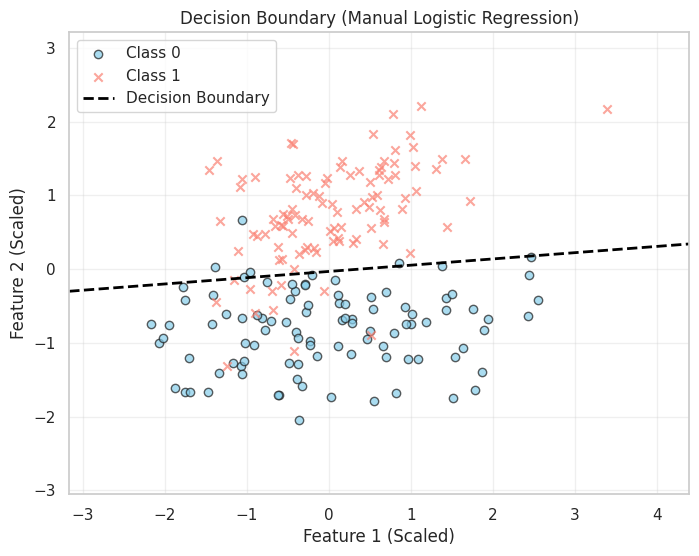

In [86]:
plot_decision_boundary(X, y, weights, bias, "Decision Boundary (Manual Logistic Regression)")

/tmp/ipykernel_1372018/333644616.py:26: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_data_np[class_1_mask, 0], X_data_np[class_1_mask, 1],


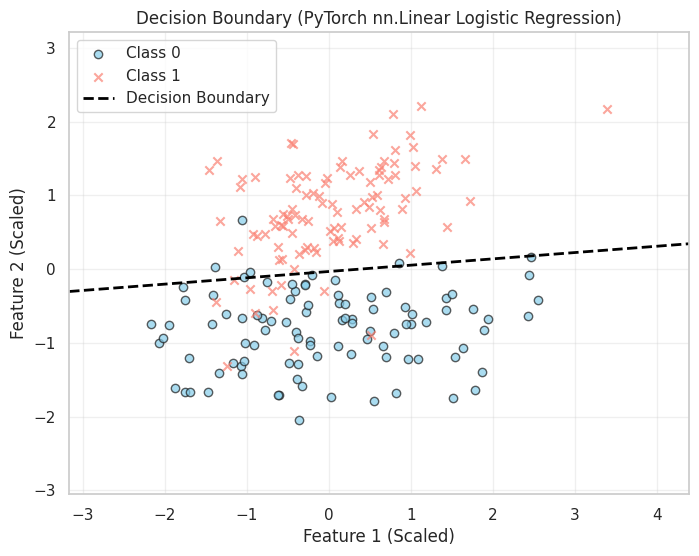

In [87]:
# plot nn.Linear model
w_nn = model_nn.linear.weight.data # Shape for nn.Linear can be [1, n_features]
b_nn = model_nn.linear.bias.data   # Shape can be [1]
plot_decision_boundary(X, y, w_nn, b_nn, "Decision Boundary (PyTorch nn.Linear Logistic Regression)")

### Model Evaluation on Test Set

In [106]:
def evaluate_classification_model(y_true_tensor, y_pred_proba_tensor, model_name="Model", threshold=0.5):
    """
    Evaluate classification model using pure PyTorch operations
    
    Args:
        y_true_tensor: Ground truth labels (torch.Tensor)
        y_pred_proba_tensor: Predicted probabilities (torch.Tensor)
        model_name: Name for display
        threshold: Classification threshold
    """
    # Ensure tensors are detached and flattened
    y_true = y_true_tensor.detach().flatten()
    y_pred_proba = y_pred_proba_tensor.detach().flatten()
    
    # Convert probabilities to binary predictions based on threshold
    y_pred_binary = (y_pred_proba >= threshold).float()

    # Sklearn
    # accuracy = accuracy_score(y_true, y_pred_binary)
    # precision = precision_score(y_true, y_pred_binary, zero_division=0)
    # recall = recall_score(y_true, y_pred_binary, zero_division=0)
    # f1 = f1_score(y_true, y_pred_binary, zero_division=0)

    # Manual
    correct = (y_pred_binary == y_true).float()
    accuracy = correct.mean()

    tp = ((y_pred_binary == 1) & (y_true == 1)).float().sum()
    fp = ((y_pred_binary == 1) & (y_true == 0)).float().sum()
    tn = ((y_pred_binary == 0) & (y_true == 0)).float().sum()
    fn = ((y_pred_binary == 0) & (y_true == 1)).float().sum()
    
    # Precision: TP / (TP + FP)
    precision = tp / (tp + fp + 1e-8)  # Add small epsilon to avoid division by zero
    
    # Recall: TP / (TP + FN)
    recall = tp / (tp + fn + 1e-8)
    
    # F1-Score: 2 * (precision * recall) / (precision + recall)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    # Confusion Matrix (convert to integers for display)
    cm_tensor = confusion_matrix(y_true, y_pred_binary)
    
    print(f"\n--- {model_name} Evaluation (Threshold={threshold}) ---")
    print(f"  Accuracy:  {accuracy.item():.4f}")
    print(f"  Precision: {precision.item():.4f}")
    print(f"  Recall:    {recall.item():.4f}")
    print(f"  F1-Score:  {f1.item():.4f}")
    print(f"  Confusion Matrix:")
    print(f"    [[TN={tn.int().item()}, FP={fp.int().item()}],")
    print(f"     [FN={fn.int().item()}, TP={tp.int().item()}]]")
    
    # Plot confusion matrix
    plt.figure(figsize=(4, 3))

    sns.heatmap(cm_tensor, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred Neg (0)', 'Pred Pos (1)'],
                yticklabels=['Actual Neg (0)', 'Actual Pos (1)'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()


--- Manual Logistic Regression Evaluation (Threshold=0.5) ---
  Accuracy:  0.9000
  Precision: 0.9565
  Recall:    0.8462
  F1-Score:  0.8980
  Confusion Matrix:
    [[TN=23, FP=1],
     [FN=4, TP=22]]


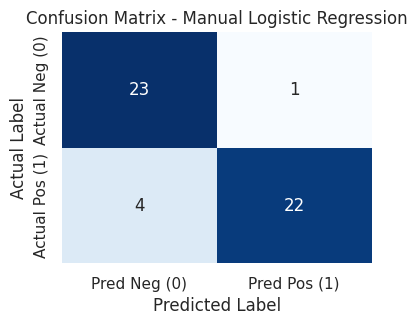

In [107]:
# Evaluate Manual Model
with torch.no_grad():
    logits_manual_test = X_test @ weights + bias
    y_pred_proba_manual_test = sigmoid(logits_manual_test)
evaluate_classification_model(y_test, y_pred_proba_manual_test, "Manual Logistic Regression")


--- PyTorch Module Logistic Regression Evaluation (Threshold=0.5) ---
  Accuracy:  0.9000
  Precision: 0.9565
  Recall:    0.8462
  F1-Score:  0.8980
  Confusion Matrix:
    [[TN=23, FP=1],
     [FN=4, TP=22]]


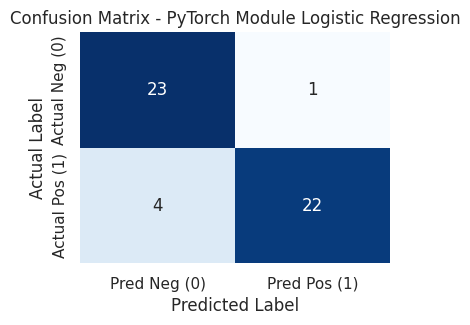

In [108]:
# Evaluate nn.Linear Model
with torch.no_grad():
    y_pred_proba_nn_test = model_nn(X_test) # Forward pass already includes sigmoid
evaluate_classification_model(y_test, y_pred_proba_nn_test, "PyTorch Module Logistic Regression")

<p>Logistic Regression uses the sigmoid function to map a linear combination of inputs to a probability (0 to 1).

- The cost function is typically Binary Cross-Entropy (Log Loss).
- We can implement it manually using autograd or leverage PyTorch's `nn.Linear`, `torch.sigmoid`, and `nn.BCELoss` (or `nn.BCEWithLogitsLoss`).
- The decision boundary for logistic regression with linear features is linear.